In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

In [6]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [7]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [8]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

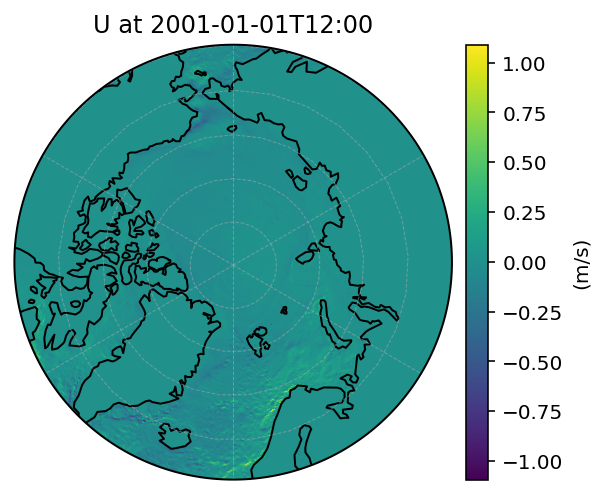

In [7]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [9]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [10]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [10]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

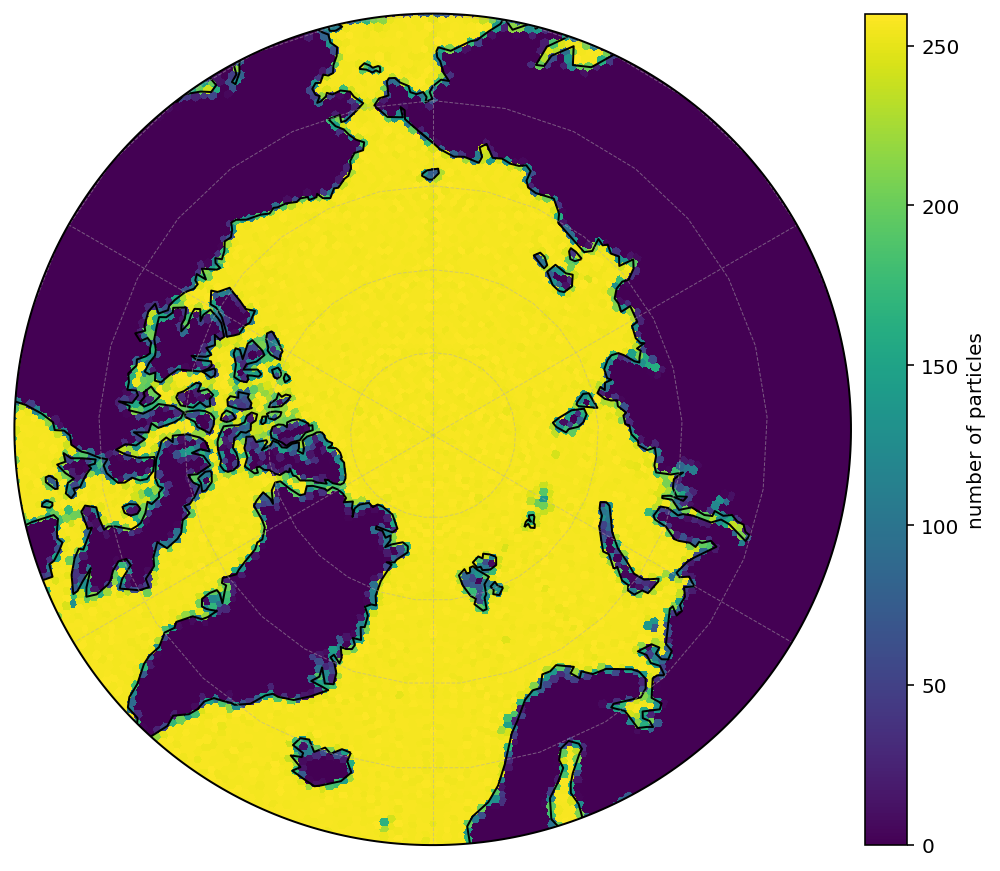

In [20]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "number of particles",
                                             size=(8,8))

# Full domain
## March 2018

In [12]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"

### 30 Days

In [ ]:
transMat_20180301 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                               myBins, 
                                               timedelta64 = np.timedelta64(30, 'D'),
                                               mask = myBins.oceanMask)
transMat_20180301.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
transMat_20180301.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")

In [27]:
transMat_20180301 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")

In [32]:
comName = runName + "_Cico7_subD30_mt2"

In [33]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8023344518411846
Global Mixing Parameter 0.32470413701587175


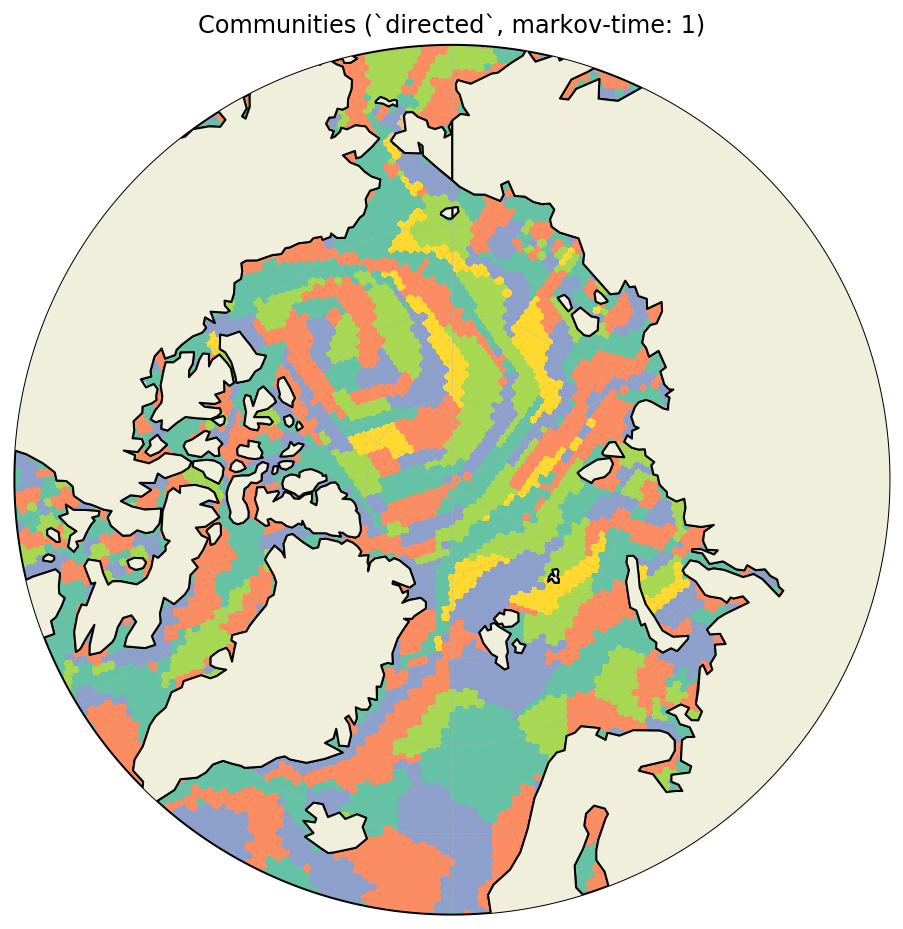

In [34]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (`directed`, markov-time: 2)"
                                            )

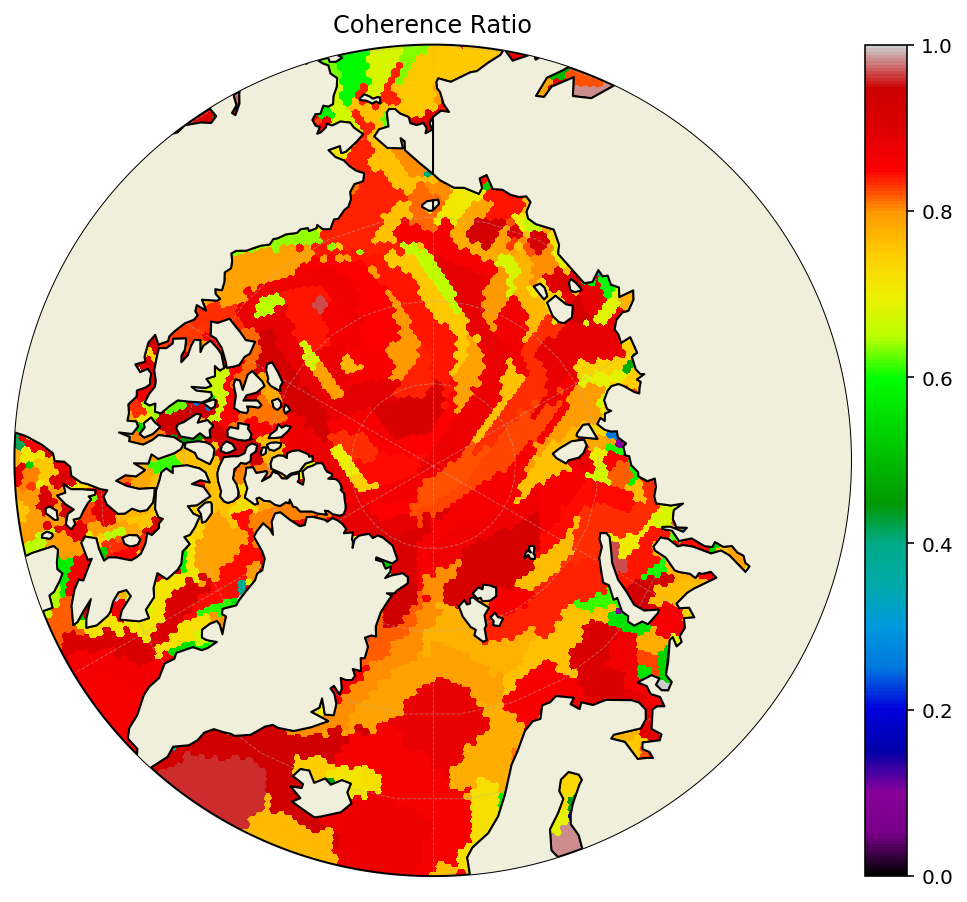

In [40]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

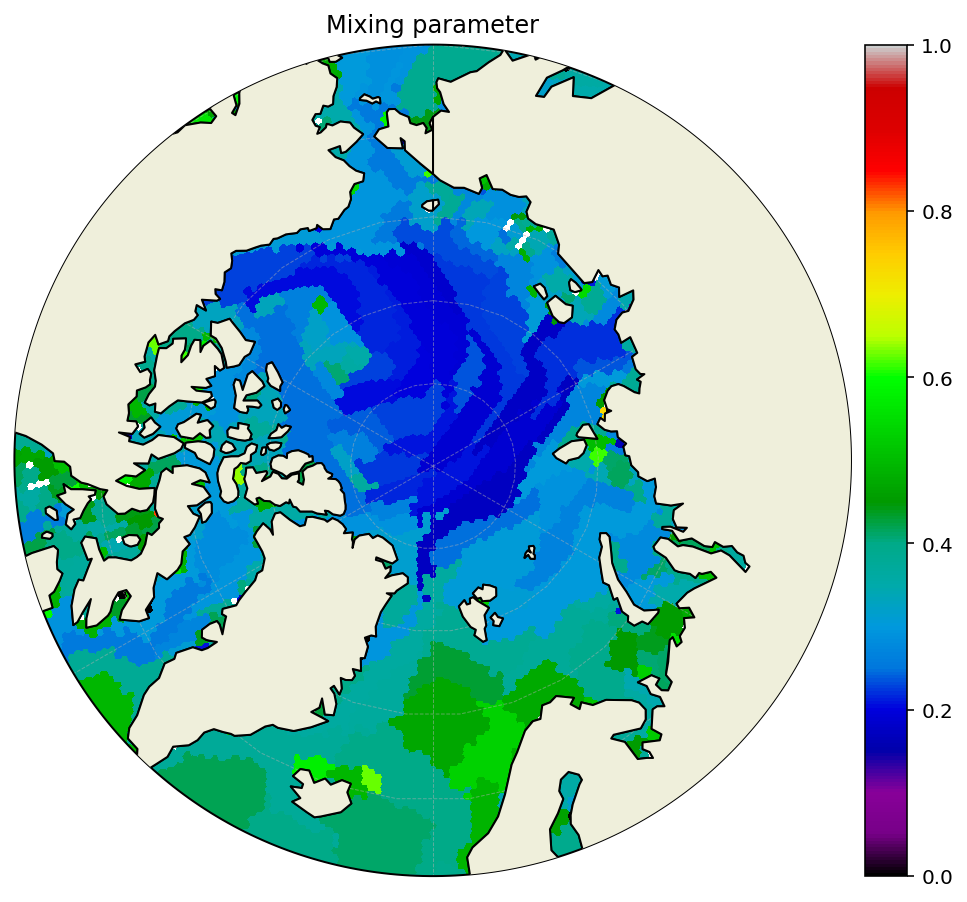

In [41]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"mixing_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Mixing parameter"
                                            )

### 90 days

In [13]:
transMat_20180301_90d = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                                 myBins, 
                                                 timedelta64 = np.timedelta64(90, 'D'),
                                                 mask = myBins.oceanMask)
transMat_20180301_90d.save_counter(matdir + f"masked_counter_{runName}_Cico7")
transMat_20180301_90d.save_network(netdir + f"masked_network_{runName}_Cico7.net")

 Determining particle bins. 100%

In [ ]:
#transMat_20180301_90d = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")

In [14]:
comName = runName + "_Cico7_mt2"

In [15]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301_90d);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301_90d);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.7885945202657414
Global Mixing Parameter 0.34209571182273524


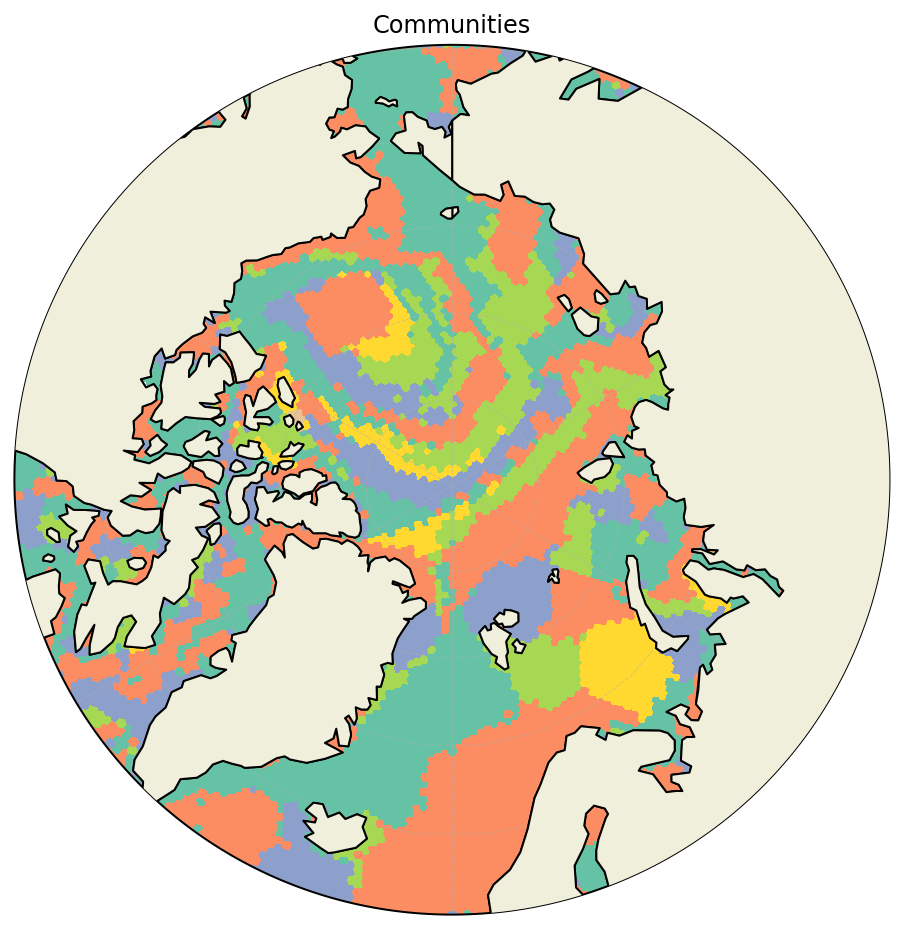

In [16]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities"
                                            )

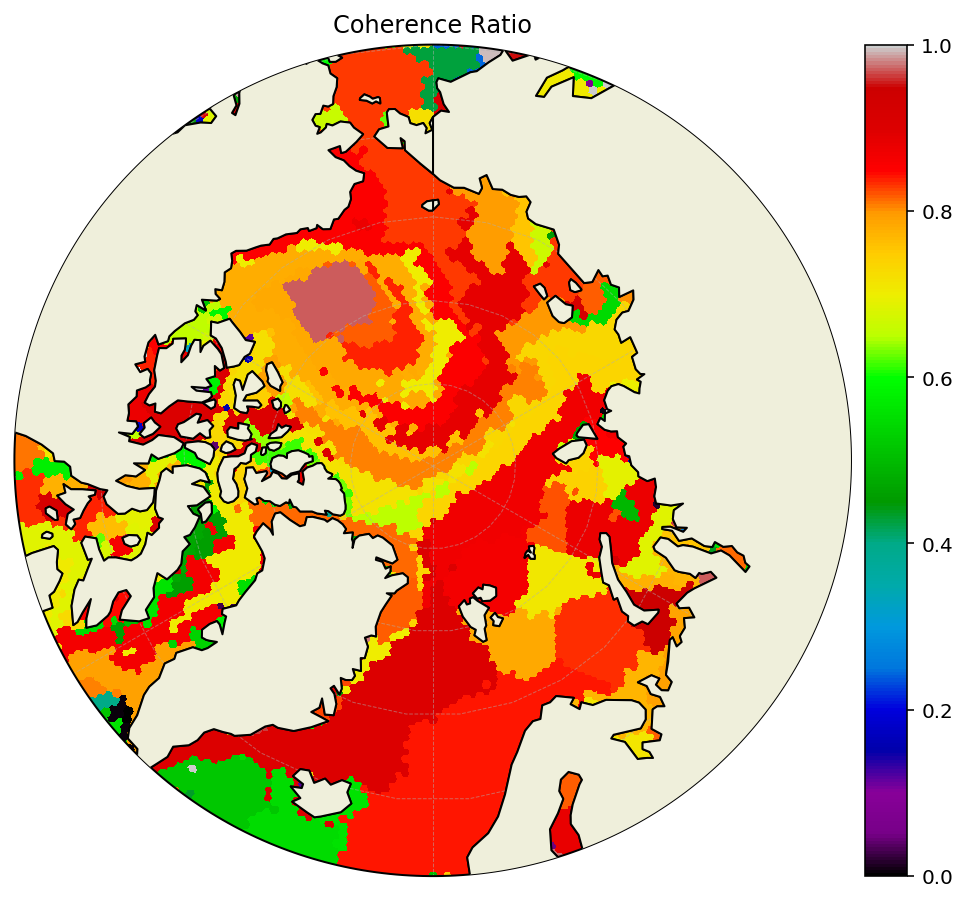

In [17]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

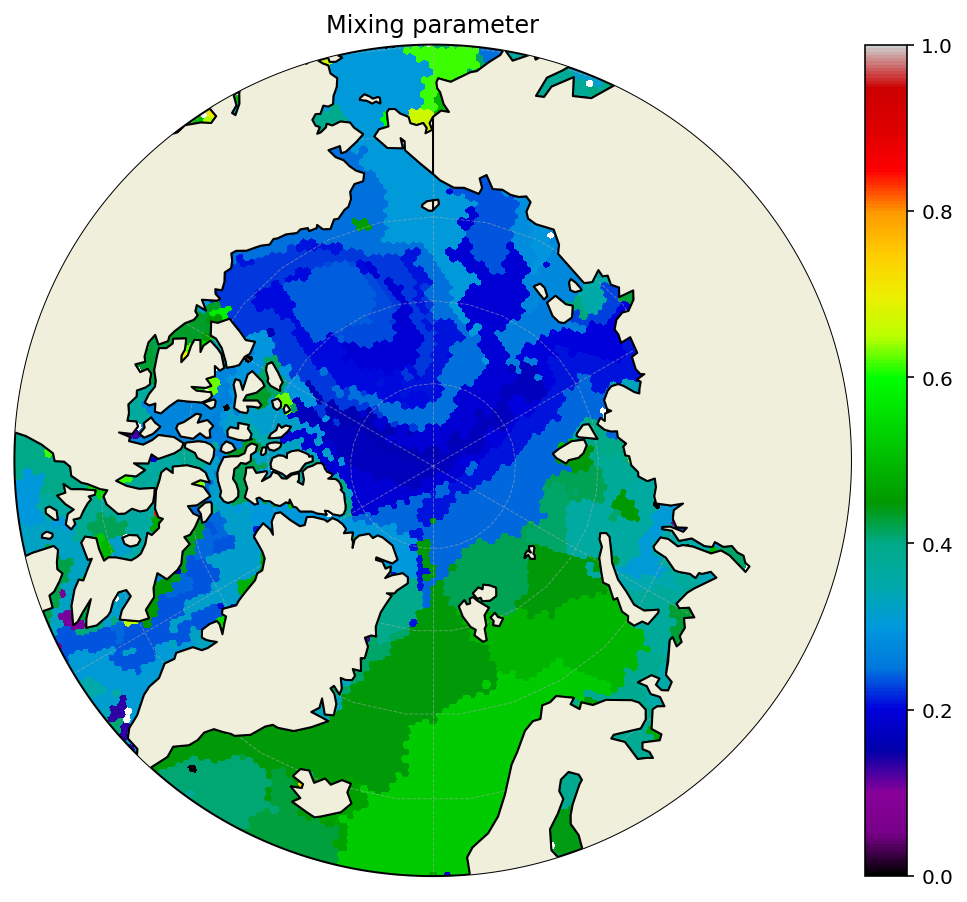

In [18]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"mixing_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Mixing parameter"
                                            )

# Boundary at different locations

## Over 65

In [19]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBinsOver65 = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMaskOver65 = community.hexMask(myBinsOver65, -180, 180, 60, 90)
myMaskOver65.growToLevel(4)
myBinsOver65.calculate_voronoi(myMaskOver65, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBinsOver65.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBinsOver65.oceanMask = pickle.load(pickFile)

In [21]:
myBinsOver65.oceanMask = np.logical_and(myBinsOver65.oceanMask, myBinsOver65.lats[myBinsOver65.mask[3]] > 65)
transMaskOver65 = myBinsOver65.lats[myBinsOver65.mask[3]][myBins.oceanMask] > 65

### 30 Days

In [ ]:
assert transMaskOver65.shape[0] == transMat_20180301.data.shape[0]
transMat_20180301_over65_killed = copy.deepcopy(transMat_20180301)
transMat_20180301_over65_killed.counter = transMat_20180301_over65_killed.counter[transMaskOver65, :][:, transMaskOver65]
transMat_20180301_over65_killed.sums = transMat_20180301_over65_killed.sums[transMaskOver65, :][:, transMaskOver65]
transMat_20180301_over65_killed.data = transMat_20180301_over65_killed.data[transMaskOver65, :][:, transMaskOver65]

In [35]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
transMat_20180301_over65.save_network(netdir + f"masked_network_over65_{runName}_Cico7_subD30.net")

In [69]:
transMat_20180301_over65_normalized = community.transMat(transMat_20180301.counter[transMaskOver65, :][:, transMaskOver65])
transMat_20180301_over65_normalized.save_network(netdir + f"masked_network_over65_normalized_{runName}_Cico7_subD30.net")

In [41]:
comName = runName + "_Cico7_subD30_mt2"
myBinsOver65.load_communities(comdir + f"masked_network_over65_{comName}.clu")
myBinsOver65.find_adjacency();
myBinsOver65.flag_on_boundary();
myBinsOver65.color_communities();
myBinsOver65.calculate_coherence_ratio(transMat_20180301_over65);
myBinsOver65.calculate_global_coherence()
myBinsOver65.calculate_mixing(transMat_20180301_over65);
myBinsOver65.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver65.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver65.globalMixing)

Global Coherence Ratio 0.8184167301979223
Global Mixing Parameter 0.31197459960166496


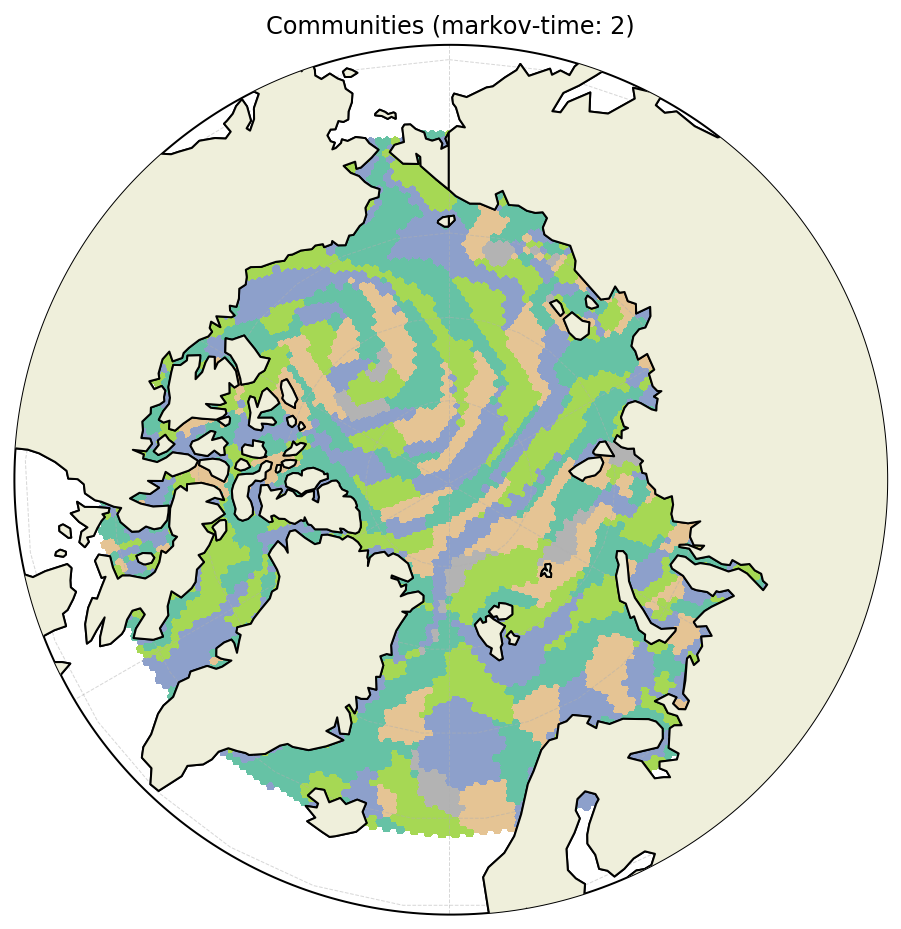

In [60]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver65.svTriLons, 
                                             myBinsOver65.svTriLats, 
                                             myBinsOver65.svSimplices[myBinsOver65.svDomainMask], 
                                             myBinsOver65.colorID[myBinsOver65.hexBindex][myBinsOver65.svSimplices[:,0][myBinsOver65.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over65_killed_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

In [65]:
print("Rows left:", transMat_20180301_over65.data.shape[0])
print("Rows for which 0<sum_of_row<1:", np.sum(np.logical_and(np.sum(transMat_20180301_over65.data, axis=1) < 1, np.sum(transMat_20180301_over65.data, axis=1) > 0)))

Rows left: 5385
Rows for which 0<sum_of_row<1: 734


In [71]:
comName = runName + "_Cico7_subD30_mt2"
myBinsOver65.load_communities(comdir + f"masked_network_over65_normalized_{comName}.clu")
myBinsOver65.find_adjacency();
myBinsOver65.flag_on_boundary();
myBinsOver65.color_communities();
myBinsOver65.calculate_coherence_ratio(transMat_20180301_over65);
myBinsOver65.calculate_global_coherence()
myBinsOver65.calculate_mixing(transMat_20180301_over65);
myBinsOver65.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver65.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver65.globalMixing)

Global Coherence Ratio 0.8200848398958739
Global Mixing Parameter 0.3106291967307364


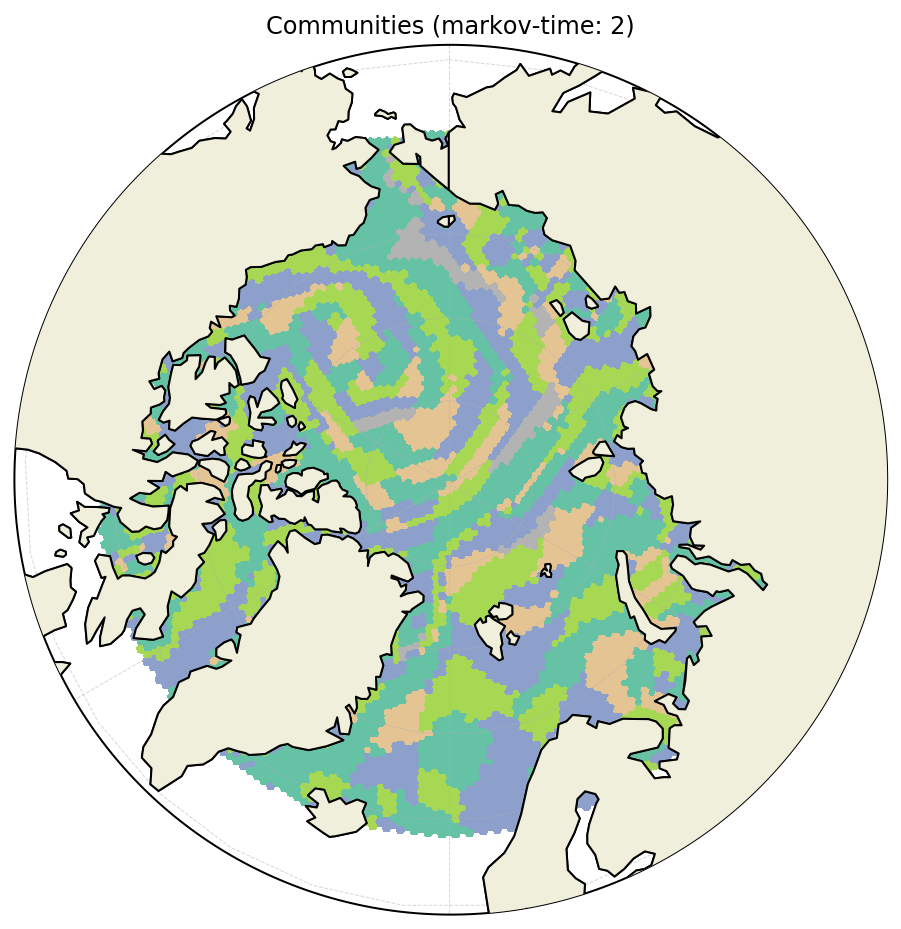

In [72]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver65.svTriLons, 
                                             myBinsOver65.svTriLats, 
                                             myBinsOver65.svSimplices[myBinsOver65.svDomainMask], 
                                             myBinsOver65.colorID[myBinsOver65.hexBindex][myBinsOver65.svSimplices[:,0][myBinsOver65.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over65_normalized_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

### 90 Days

In [24]:
assert transMaskOver65.shape[0] == transMat_20180301_90d.data.shape[0]
transMat_20180301_90d_over65_killed = copy.deepcopy(transMat_20180301_90d)
transMat_20180301_90d_over65_killed.counter = transMat_20180301_90d_over65_killed.counter[transMaskOver65, :][:, transMaskOver65]
transMat_20180301_90d_over65_killed.sums = transMat_20180301_90d_over65_killed.sums[transMaskOver65, :][:, transMaskOver65]
transMat_20180301_90d_over65_killed.data = transMat_20180301_90d_over65_killed.data[transMaskOver65, :][:, transMaskOver65]

In [25]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
transMat_20180301_90d_over65_killed.save_network(netdir + f"masked_network_over65_killed_{runName}_Cico7.net")

In [26]:
transMat_20180301_90d_over65_normalized = community.transMat(transMat_20180301_90d.counter[transMaskOver65, :][:, transMaskOver65])
transMat_20180301_90d_over65_normalized.save_network(netdir + f"masked_network_over65_normalized_{runName}_Cico7.net")

In [30]:
comName = runName + "_Cico7_mt2"
myBinsOver65.load_communities(comdir + f"masked_network_over65_killed_{comName}.clu")
myBinsOver65.find_adjacency();
myBinsOver65.flag_on_boundary();
myBinsOver65.color_communities();
myBinsOver65.calculate_coherence_ratio(transMat_20180301_90d_over65_killed);
myBinsOver65.calculate_global_coherence()
myBinsOver65.calculate_mixing(transMat_20180301_90d_over65_killed);
myBinsOver65.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver65.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver65.globalMixing)

Global Coherence Ratio 0.7954955326641784
Global Mixing Parameter 0.328600907230718


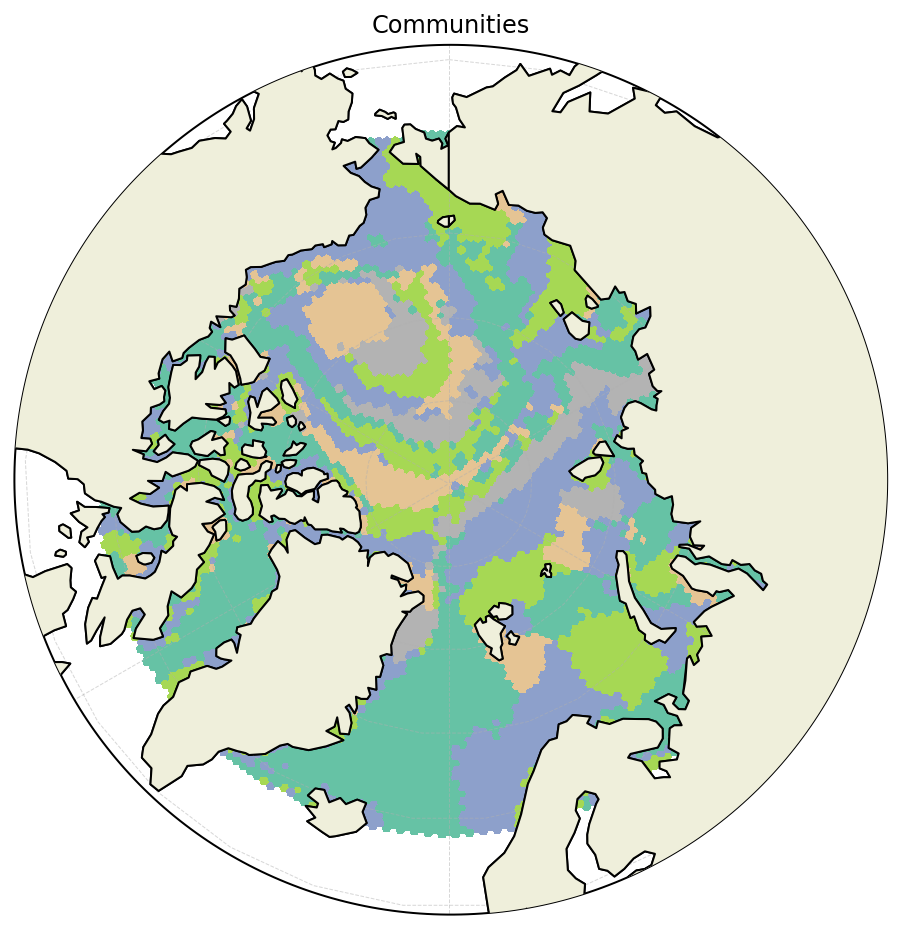

In [32]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver65.svTriLons, 
                                             myBinsOver65.svTriLats, 
                                             myBinsOver65.svSimplices[myBinsOver65.svDomainMask], 
                                             myBinsOver65.colorID[myBinsOver65.hexBindex][myBinsOver65.svSimplices[:,0][myBinsOver65.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over65_killed_{comName}",
                                            title = "Communities"
                                            )

In [33]:
print("Rows left:", transMat_20180301_90d_over65_killed.data.shape[0])
print("Rows for which 0<sum_of_row<1:", np.sum(np.logical_and(np.sum(transMat_20180301_90d_over65_killed.data, axis=1) < 1, np.sum(transMat_20180301_90d_over65_killed.data, axis=1) > 0)))

Rows left: 5385
Rows for which 0<sum_of_row<1: 1364


In [34]:
comName = runName + "_Cico7_mt2"
myBinsOver65.load_communities(comdir + f"masked_network_over65_normalized_{comName}.clu")
myBinsOver65.find_adjacency();
myBinsOver65.flag_on_boundary();
myBinsOver65.color_communities();
myBinsOver65.calculate_coherence_ratio(transMat_20180301_90d_over65_normalized);
myBinsOver65.calculate_global_coherence()
myBinsOver65.calculate_mixing(transMat_20180301_90d_over65_normalized);
myBinsOver65.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver65.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver65.globalMixing)

Global Coherence Ratio 0.8005932213912899
Global Mixing Parameter 0.3250101012993143


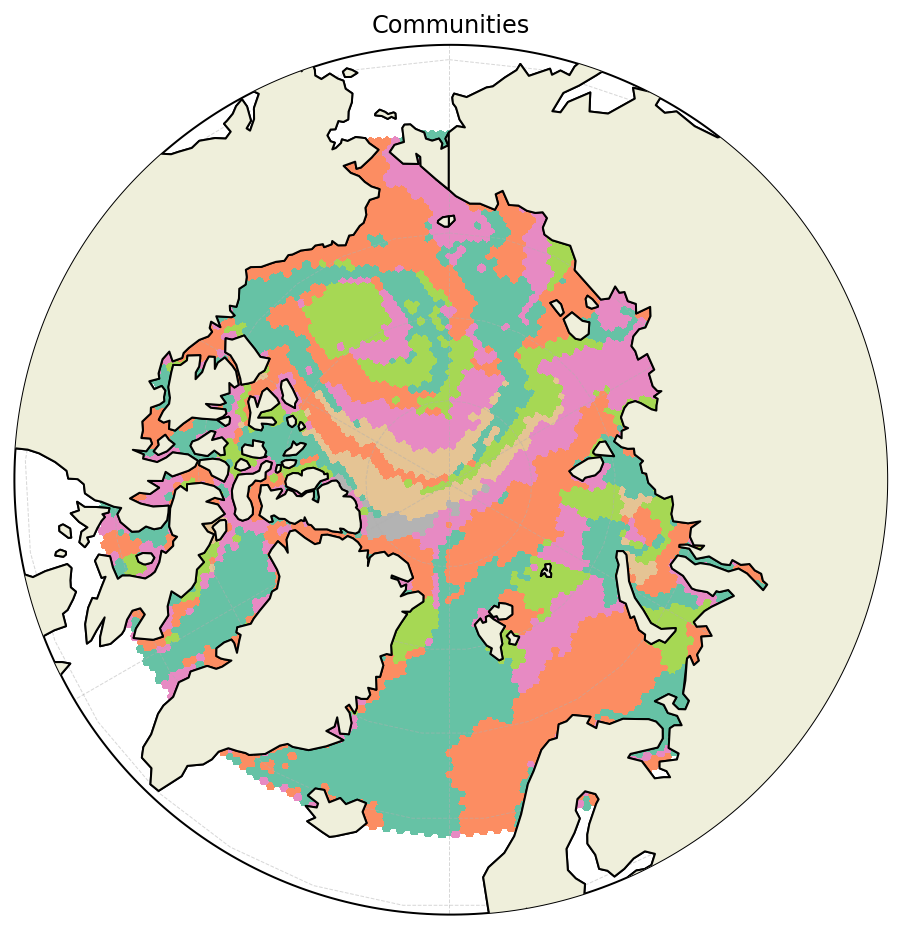

In [35]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver65.svTriLons, 
                                             myBinsOver65.svTriLats, 
                                             myBinsOver65.svSimplices[myBinsOver65.svDomainMask], 
                                             myBinsOver65.colorID[myBinsOver65.hexBindex][myBinsOver65.svSimplices[:,0][myBinsOver65.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over65_normalized_{comName}",
                                            title = "Communities"
                                            )

## Over 70

In [36]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBinsOver70 = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMaskOver70 = community.hexMask(myBinsOver70, -180, 180, 60, 90)
myMaskOver70.growToLevel(4)
myBinsOver70.calculate_voronoi(myMaskOver70, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBinsOver70.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBinsOver70.oceanMask = pickle.load(pickFile)

In [37]:
myBinsOver70.oceanMask = np.logical_and(myBinsOver70.oceanMask, myBinsOver70.lats[myBinsOver70.mask[3]] > 70)
transMaskOver70 = myBinsOver70.lats[myBinsOver70.mask[3]][myBins.oceanMask] > 70

### 30 days

In [86]:
assert transMaskOver70.shape[0] == transMat_20180301.data.shape[0]
transMat_20180301_over70_killed = copy.deepcopy(transMat_20180301)
transMat_20180301_over70_killed.counter = transMat_20180301_over70_killed.counter[transMaskOver70, :][:, transMaskOver70]
transMat_20180301_over70_killed.sums = transMat_20180301_over70_killed.sums[transMaskOver70, :][:, transMaskOver70]
transMat_20180301_over70_killed.data = transMat_20180301_over70_killed.data[transMaskOver70, :][:, transMaskOver70]

In [87]:
print("Rows left:", transMat_20180301_over70.data.shape[0])
print("Rows for which 0<sum_of_row<1:", np.sum(np.logical_and(np.sum(transMat_20180301_over70_killed.data, axis=1) < 1, np.sum(transMat_20180301_over70_killed.data, axis=1) > 0)))

Rows left: 4344
Rows for which 0<sum_of_row<1: 653


In [46]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
transMat_20180301_over70_killed.save_network(netdir + f"masked_network_over70_{runName}_Cico7_subD30.net")

In [70]:
transMat_20180301_over70_normalized = community.transMat(transMat_20180301.counter[transMaskOver70, :][:, transMaskOver70])
transMat_20180301_over70_normalized.save_network(netdir + f"masked_network_over70_normalized_{runName}_Cico7_subD30.net")

In [88]:
comName = runName + "_Cico7_subD30_mt2"
myBinsOver70.load_communities(comdir + f"masked_network_over70_killed_{comName}.clu")
myBinsOver70.find_adjacency();
myBinsOver70.flag_on_boundary();
myBinsOver70.color_communities();
myBinsOver70.calculate_coherence_ratio(transMat_20180301_over70_killed);
myBinsOver70.calculate_global_coherence()
myBinsOver70.calculate_mixing(transMat_20180301_over70_killed);
myBinsOver70.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver70.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver70.globalMixing)

Global Coherence Ratio 0.8249333846866814
Global Mixing Parameter 0.2935293978947637


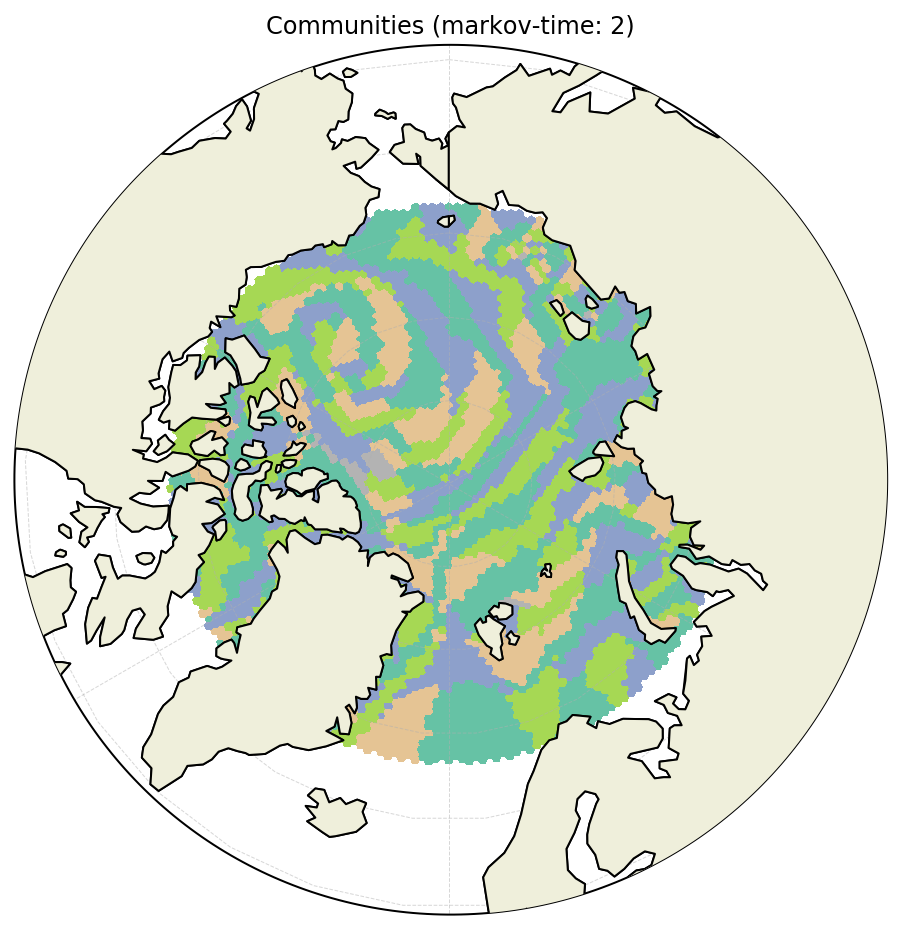

In [61]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.colorID[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over70_killed_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

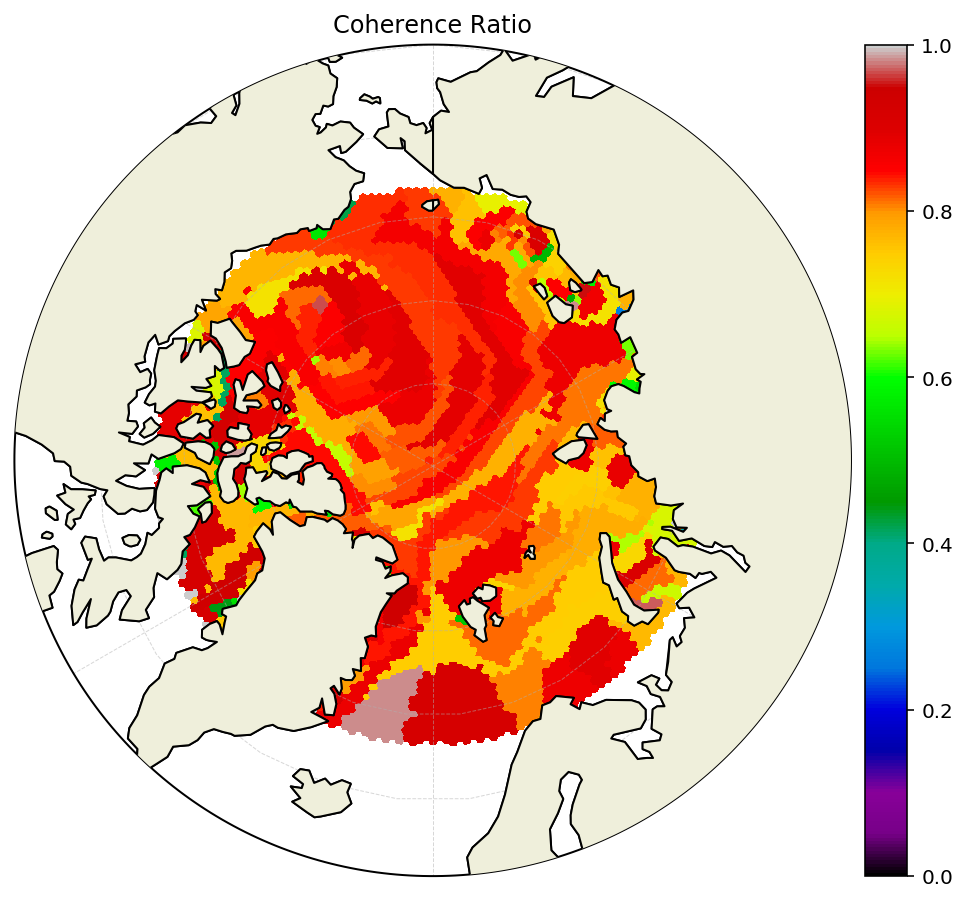

In [89]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.coherenceRatio[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_over70_killed_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

In [91]:
comName = runName + "_Cico7_subD30_mt2"
myBinsOver70.load_communities(comdir + f"masked_network_over70_normalized_{comName}.clu")
myBinsOver70.find_adjacency();
myBinsOver70.flag_on_boundary();
myBinsOver70.color_communities();
myBinsOver70.calculate_coherence_ratio(transMat_20180301_over70_normalized);
myBinsOver70.calculate_global_coherence()
myBinsOver70.calculate_mixing(transMat_20180301_over70_normalized);
myBinsOver70.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver70.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver70.globalMixing)

Global Coherence Ratio 0.8181736555476736
Global Mixing Parameter 0.2928168940159519


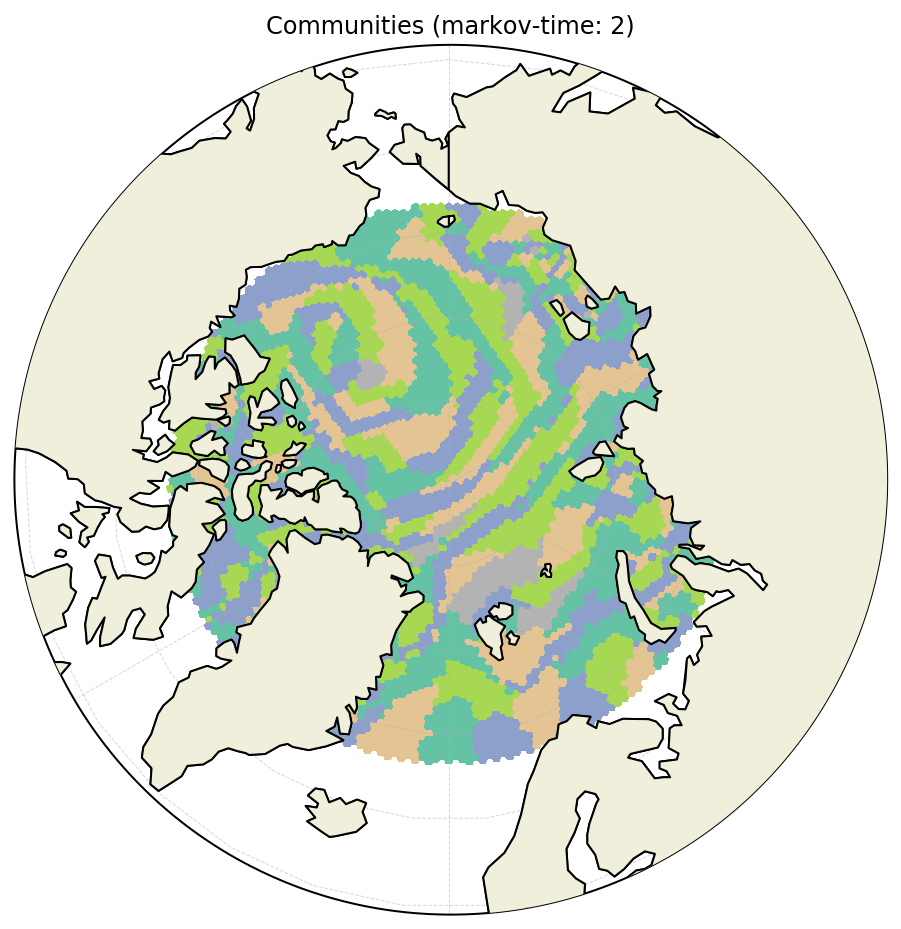

In [74]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.colorID[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over70_normalized_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

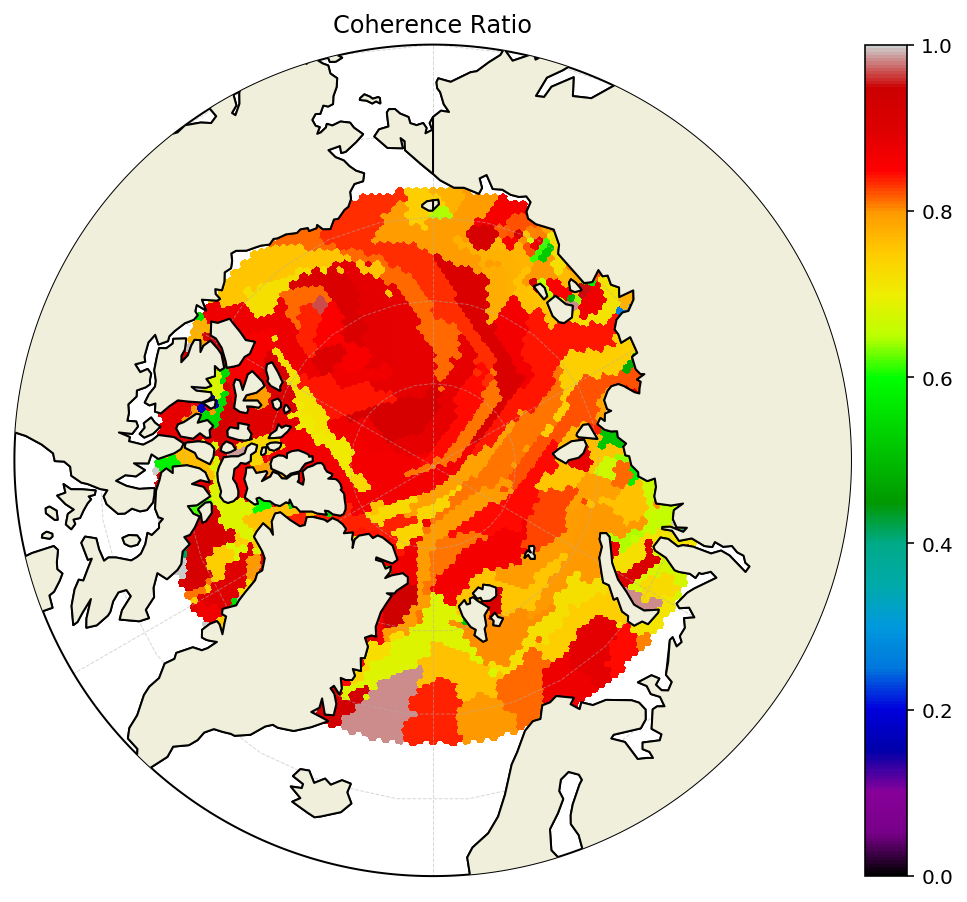

In [92]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.coherenceRatio[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_over70_normalized_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

### 90 Days

In [38]:
assert transMaskOver70.shape[0] == transMat_20180301_90d.data.shape[0]
transMat_20180301_90_d_over70_killed = copy.deepcopy(transMat_20180301_90d)
transMat_20180301_90_d_over70_killed.counter = transMat_20180301_90_d_over70_killed.counter[transMaskOver70, :][:, transMaskOver70]
transMat_20180301_90_d_over70_killed.sums = transMat_20180301_90_d_over70_killed.sums[transMaskOver70, :][:, transMaskOver70]
transMat_20180301_90_d_over70_killed.data = transMat_20180301_90_d_over70_killed.data[transMaskOver70, :][:, transMaskOver70]

In [39]:
print("Rows left:", transMat_20180301_90_d_over70_killed.data.shape[0])
print("Rows for which 0<sum_of_row<1:", np.sum(np.logical_and(np.sum(transMat_20180301_90_d_over70_killed.data, axis=1) < 1, np.sum(transMat_20180301_90_d_over70_killed.data, axis=1) > 0)))

Rows left: 4344
Rows for which 0<sum_of_row<1: 1107


In [40]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
transMat_20180301_90d_over70_killed.save_network(netdir + f"masked_network_over70_killed_{runName}_Cico7.net")

In [41]:
transMat_20180301_90d_over70_normalized = community.transMat(transMat_20180301_90d.counter[transMaskOver70, :][:, transMaskOver70])
transMat_20180301_90d_over70_normalized.save_network(netdir + f"masked_network_over70_normalized_{runName}_Cico7.net")

In [42]:
comName = runName + "_Cico7_mt2"
myBinsOver70.load_communities(comdir + f"masked_network_over70_killed_{comName}.clu")
myBinsOver70.find_adjacency();
myBinsOver70.flag_on_boundary();
myBinsOver70.color_communities();
myBinsOver70.calculate_coherence_ratio(transMat_20180301_90d_over70_killed);
myBinsOver70.calculate_global_coherence()
myBinsOver70.calculate_mixing(transMat_20180301_90d_over70_killed);
myBinsOver70.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver70.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver70.globalMixing)

Global Coherence Ratio 0.8098107511171008
Global Mixing Parameter 0.31026180958821054


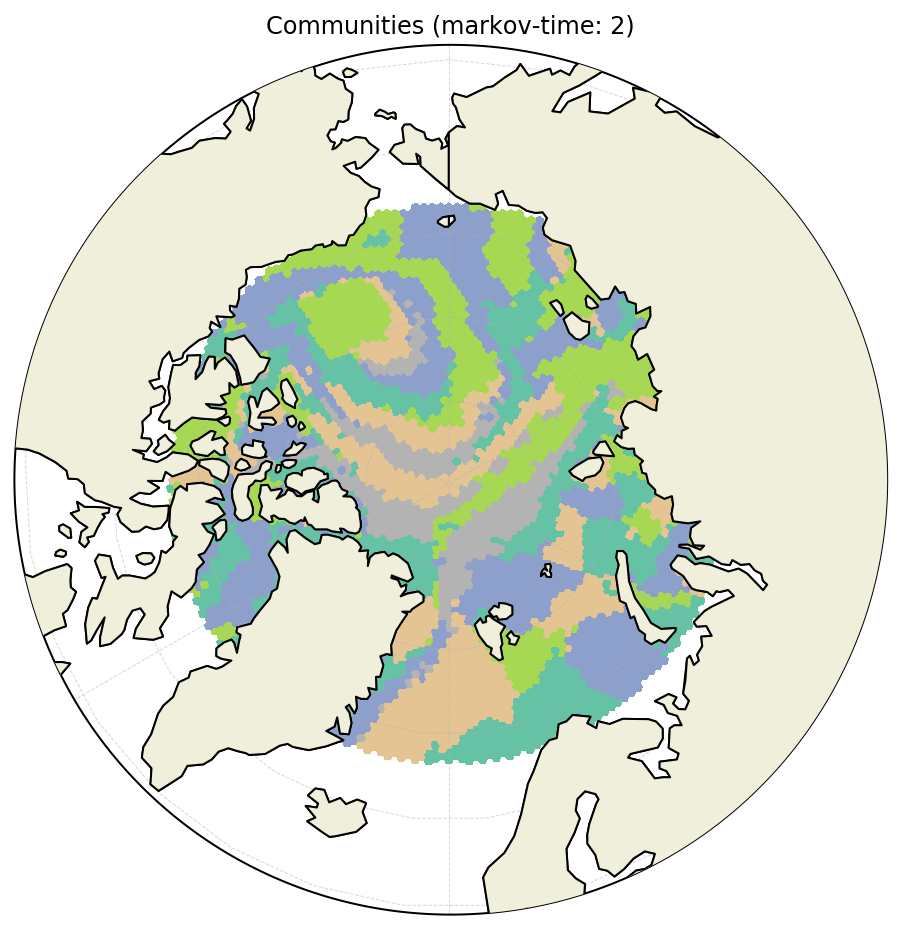

In [43]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.colorID[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over70_killed_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

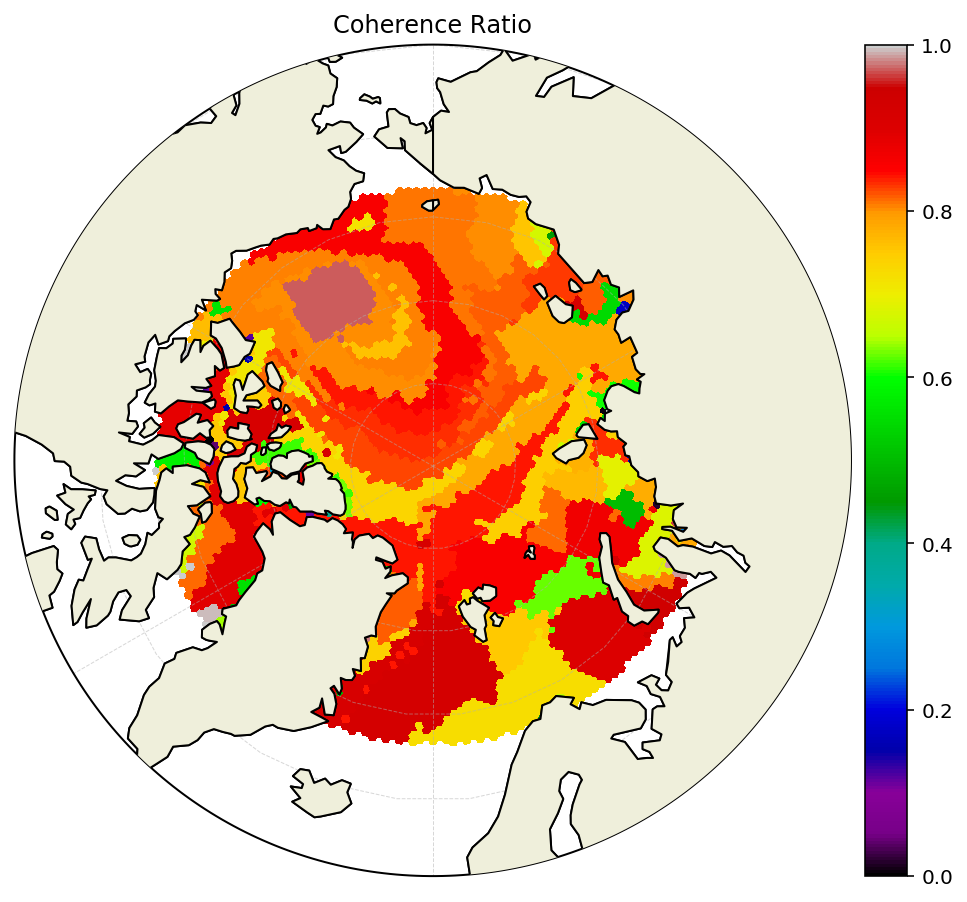

In [44]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.coherenceRatio[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_over70_killed_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

In [45]:
comName = runName + "_Cico7_mt2"
myBinsOver70.load_communities(comdir + f"masked_network_over70_normalized_{comName}.clu")
myBinsOver70.find_adjacency();
myBinsOver70.flag_on_boundary();
myBinsOver70.color_communities();
myBinsOver70.calculate_coherence_ratio(transMat_20180301_90d_over70_normalized);
myBinsOver70.calculate_global_coherence()
myBinsOver70.calculate_mixing(transMat_20180301_90d_over70_normalized);
myBinsOver70.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver70.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver70.globalMixing)

Global Coherence Ratio 0.8052807580832188
Global Mixing Parameter 0.3084321009466242


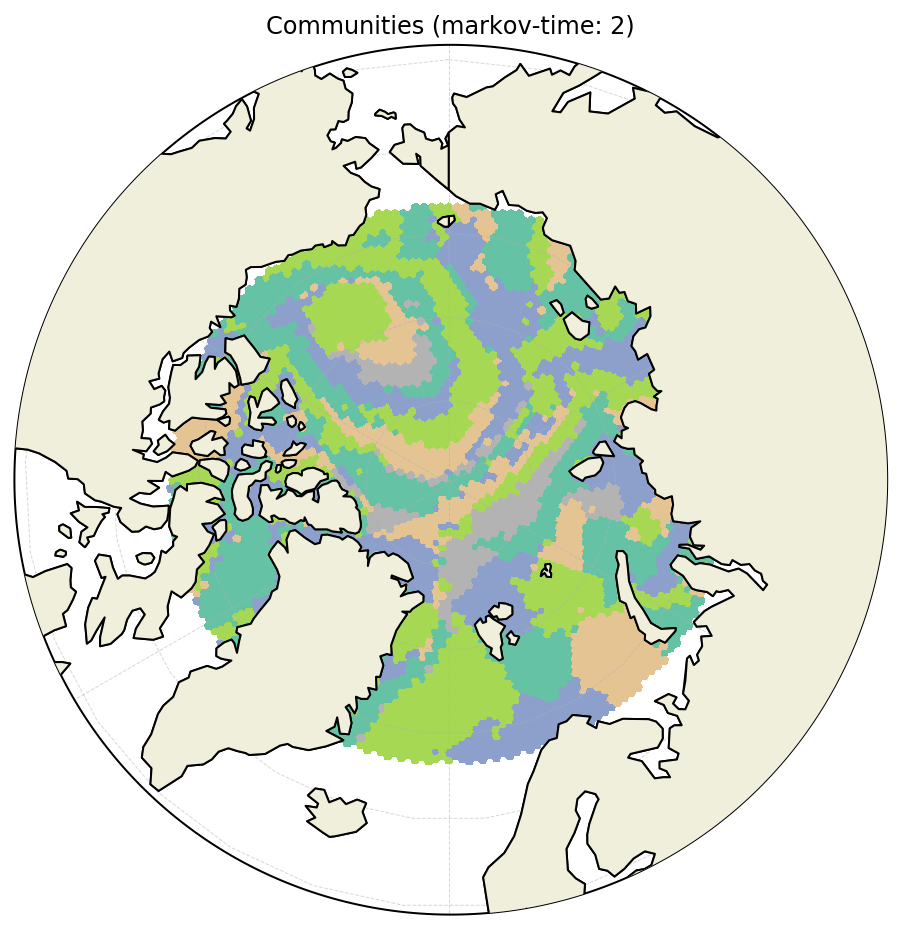

In [46]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.colorID[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over70_normalized_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

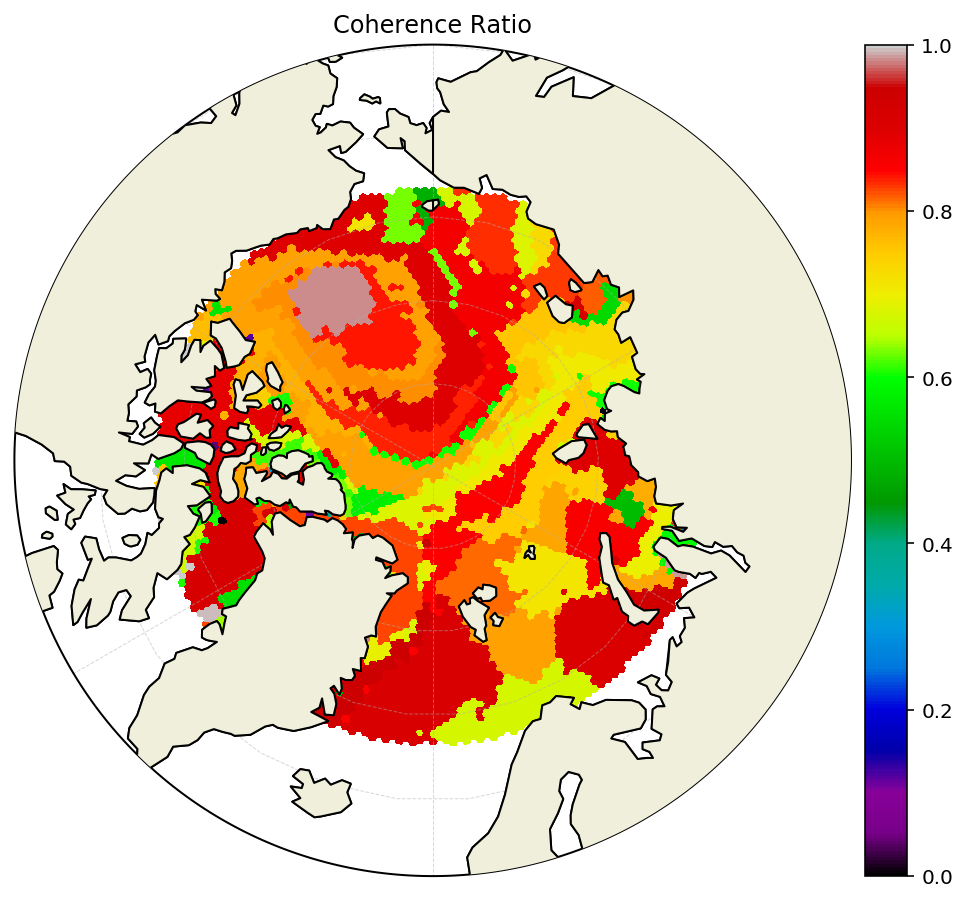

In [47]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.coherenceRatio[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_over70_normalized_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )